In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import random
import os
import time
import copy
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import csv

In [2]:
cwd = os.getcwd()

In [78]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in C:\Users\anton/.cache\torch\hub\pytorch_vision_v0.10.0


In [4]:
print(torch. __version__)
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# Find out if a GPU is available
use_cuda = torch.cuda.is_available()
use_cuda

2.2.1+cu118
cuda


True

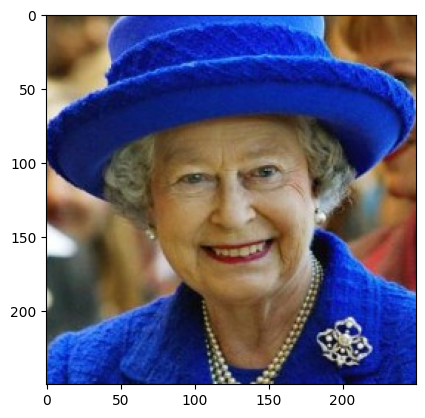

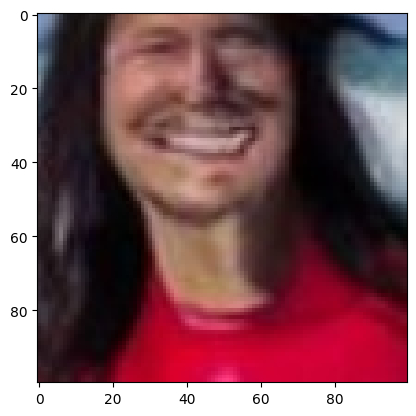

In [15]:
auxiliary_data = cwd + os.sep + 'images' + os.sep + 'auxiliary_data_set' + os.sep + 'lfw' + os.sep
target_model_data = cwd + os.sep + 'images' + os.sep + 'target_model' + os.sep + 'stable_diffusion_1_4_paper' + os.sep
root_data = cwd + os.sep + 'images' + os.sep

# Display image for reference
img = Image.open(auxiliary_data + 'Queen_Elizabeth_II_0001.jpg')
plt.imshow(img)
plt.show()

img = Image.open(target_model_data + '00000.jpeg')
plt.imshow(img)
plt.show()


In [79]:
def create_dataset_train(parent_dir):
    # Define your transformations
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    dataset = datasets.ImageFolder(parent_dir, transform=transform)
    
    return dataset




In [80]:
# Get the train_dataset
train_dataset = create_dataset_train(root_data)
# Get the validation_dataset
train_set, val_set = torch.utils.data.random_split(train_dataset, [int(0.8*len(train_dataset)), int(0.2*len(train_dataset)+1)])


# Display the shape of the train_dataset
print(len(train_set))
# Display the shape of the test_dataset
print(len(val_set))
# make a dataLoader
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)


14001
3501


In [81]:
class_names = train_dataset.classes
print('Class names:', class_names)

Class names: ['auxiliary_data_set', 'target_model']


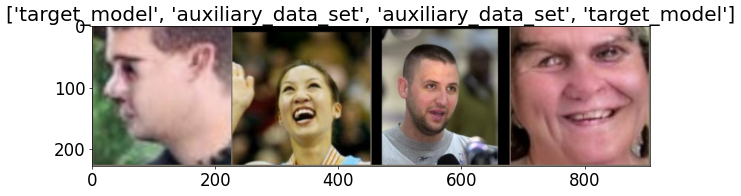

In [82]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [83]:
num_features = model.fc.in_features 
print('Number of features from pre-trained model', num_features)

# Add a fully-connected layer for classification
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

Number of features from pre-trained model 512


In [84]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [85]:
#### Train model
train_loss = []
train_accuary = []
val_loss = []
val_accuary = []

num_epochs = 5   
start_time = time.time() 


for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))

    """ Validation Phase """
    model.eval()    #(evaluation model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(val_set)
    epoch_acc = running_corrects / len(val_set) * 100.
    # Append result
    val_loss.append(epoch_loss)
    val_accuary.append(epoch_acc)
    # Print progress
    print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))



Epoch 0 running


In [ ]:
test_loss=[]
test_accuary=[]
    
# """ Testing Phase """
    # model.eval()
    # with torch.no_grad():
    #     running_loss = 0.
    #     running_corrects = 0
    #     for inputs, labels in test_dataloader:
    #         inputs = inputs.to(device)
    #         labels = labels.to(device)
    #         outputs = model(inputs)
    #         _, preds = torch.max(outputs, 1)
    #         loss = criterion(outputs, labels)
    #         running_loss += loss.item()
    #         running_corrects += torch.sum(preds == labels.data).item()
    #     epoch_loss = running_loss / len(test_dataset)
    #     epoch_acc = running_corrects / len(test_dataset) * 100.
    #     # Append result
    #     test_loss.append(epoch_loss)
    #     test_accuary.append(epoch_acc)
    #     # Print progress
    #     print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

In [ ]:
save_path = 'custom-classifier_resnet_18_final.pth'
torch.save(model.state_dict(), save_path)

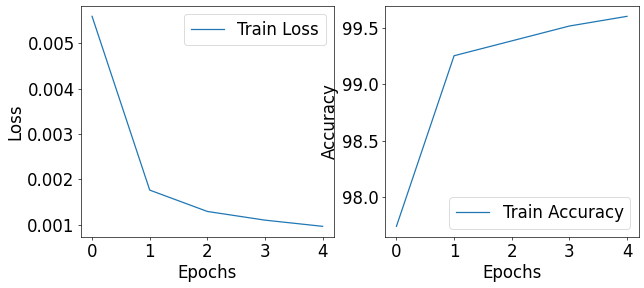

In [ ]:
# Visualize the training process on two plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuary, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize the validation process on two plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_accuary, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
